In [1]:
# Insert below the path of the developer version of pyBBarolo (= the git repo)
# This way, we can override any other installed version and 
# modify pyBBarolo without the need of reinstalling it every time
import sys
sys.path.insert(0, "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7")

# i just copied the repository

# This should give version 1.3.2dev!
from pyBBarolo import version
print (version)
import pyBBarolo as BB
import pyBBarolo.utils as ut
from pyBBarolo.bayesian import BayesianBBarolo

from dynesty import plotting as dyplot
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import os, subprocess
from astropy.io import fits
BBmain = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/BBarolo"


1.3.2dev


[RN-145-90-181-229.eduroam.rug.nl:41502] shmem: mmap: an error occurred while determining whether or not /var/folders/jn/tjkfv7yj6vx0n23cdyjdp_9w0000gn/T//ompi.RN-145-90-181-229.501/jf.0/3962830848/sm_segment.RN-145-90-181-229.501.ec340000.0 could be created.


In [ ]:
# Name of the FITS file to be fitted
fitsname = "/Users/blanca/Documents/TESIS/software/code/models/modelwith0.0015rms.fits"
ringfile = "/Users/blanca/Documents/TESIS/software/code/models/modelwith0.0015rms_params.txt"
outputfile = "/Users/blanca/Documents/TESIS/software/code/tests/newmodeltest_constvdisp_2/"

## Fitting:

In [ ]:
# f = BB.Search._compute(fitsname) i think this might do something formy problem 

# Creating an object for bayesian barolo
f3d = BayesianBBarolo(fitsname)
th  = multiprocessing.cpu_count() #this counts my cpu so that the code can run with all of them

# Initializing rings. All parameters should be given.
# No-fitted parameters will be used for all models, while fitted parameters 
# are actually not even used for initial guesses.
rad=np.arange(180,1250,180)     

f3d.init(radii=rad,xpos=36.959,ypos=38.199,vsys=0.0,\
         vrot=120,vdisp=8,vrad=0,z0=0,inc=50.988,phi=124.147)
# so basically if all the parameters are free the initial guesses are irrelevant?

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0.85)
f3d.show_options()

# Default priors are uniform and the default boundaries for the fit are in f3d.bounds. ****
# Here I modify some of them to help convergence for this particular galaxy. --> adapt for every cube!!

#THESE ARE THE BOUNDS ENRICO USED: so the bounds for model 1
#f3d.bounds['vrot']  = [0,250]
#f3d.bounds['vdisp'] = [0,40]
#f3d.bounds['inc']   = [50,70]
#f3d.bounds['phi']   = [20,40]
#f3d.bounds['z0']    = [0,60]
#f3d.bounds['xpos']  = [20,30]
#f3d.bounds['ypos']  = [20,30]
#f3d.bounds['vsys']  = [-20,20] 

f3d.bounds['vrot']  = [0,200]
f3d.bounds['vdisp'] = [0,40]
#f3d.bounds['inc']   = [40,60]
#f3d.bounds['phi']   = [120,130] #123.7 [300,350]
#f3d.bounds['z0']    = [0,10] 
#f3d.bounds['xpos']  = [73,78] #[30,45]
#f3d.bounds['ypos']  = [73,78] #[30,45]
f3d.bounds['vsys']  = [110,150] 

# Running the fit with dynesty.
# To fit a parameter ring-by-ring, just use the parameter name in freepar
# To fit a parameter with a single value, add a '_single' to the parameter name
# In this example, I fit 14 parameters: 4 vrot, 4 vdisp, 1 inc, 1 pa, 1 z0, 1 xpos, 1 ypos and 1 vsys
f3d.compute(threads=th, method='dynesty',freepar=['vrot','vdisp',
                                                  #'inc_single','phi_single',
                                      #'z0_single',
                                      #'xpos_single','ypos_single',
                                      'vsys_single'])

#.savefig(outputfile+'mask.pdf',bbox_inches='tight')

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/code/models/modelwith0.0015rms.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 

##### Input parameters for BBarolo #####
FITSFILE           /Users/blanca/Documents/TESIS/software/code/models/modelwith0.0015rms.fits 
MASK               SEARCH 
LINEAR             0.85 



17169it [49:08,  5.82it/s, batch: 4 | bound: 46 | nc: 1 | ncall: 497367 | eff(%):  3.344 | loglstar: -16.436 < -6.130 < -8.938 | logz: -17.937 +/-  0.094 | stop:  0.760]          

[104.54055192 130.23354752 137.35142417 140.67094818 149.07206067
 146.7434144   19.88110975  19.93966555  19.84471138  20.58672287
  19.52263685  17.93630406 134.22321535]


## Model of resulting parameters:

In [4]:
print(f3d.freepar_idx)
#print(f3d.freepar_names)
print(f3d.ndim)


#we calculate the parameters of the initial mock
# Open the FITS file
hdul = fits.open(fitsname)
modname   = 'barbamodel' #this is the name of the model
# Get the header of the primary HDU (Header Data Unit)
fi = hdul[0].header
#these are the sizes
xaxis = fi['NAXIS1']
yaxis = fi['NAXIS2']
zaxis = fi['NAXIS3']
xaxis = fi['NAXIS1']
#here the cdelts
pix1 = np.abs(fi['CDELT1']) #check if this works!
pix2 = fi['CDELT2']
chan = fi['CDELT3']
# the beam
bea = fi['BMAJ']

#creating the shape of the model
sim = ut.SimulatedGalaxyCube(axisDim=[xaxis, yaxis, zaxis],\
                        cdelts=[pix1, pix2, chan],\
                        beam=bea, bunit='JY/BEAM', obj=modname)


#we set the parameters
vel  = f3d.params[f3d.freepar_idx["vrot"]]
disp = f3d.params[f3d.freepar_idx["vdisp"]]
inn  = np.full(len(rad), 50.988)    # 50.988 #f3d.params[f3d.freepar_idx["inc"]]
phi  = np.full(len(rad), 24.147)    # 24.147 #f3d.params[f3d.freepar_idx["phi"]]
z0d   = np.full(len(rad),0.000)   #f3d.params[f3d.freepar_idx["z0"]]
xpos = np.full(len(rad),36.959)    # 36.959 #f3d.params[f3d.freepar_idx["xpos"]]
ypos = np.full(len(rad),38.199)    # 38.199 #f3d.params[f3d.freepar_idx["ypos"]]
vsy = np.full(len(rad),f3d.params[f3d.freepar_idx["vsys"]])
dens   = np.full(len(rad),1)
#50*np.exp(-rad/400-100/(0.5*rad+100)) #I will do this for now but ideally this is in the bbarolo?
#noiserms  = 0.08 #again i need to find a way to get this number?


# Setting up galaxy parameters (if parameters are not given, they are random!)
sim.define_galaxy(radii=rad,vsys=vsy,vdisp=disp,inc=inn,pa=phi,\
                dens=dens,z0=z0d,vrot=vel,warpinc=False,warppa=False)
print(sim)

# Running BB and creating a model
print (f"Simulating {modname}...",flush=True,end='')
sim.run(exe=BBmain, stdout='null', outfolder=outputfile+modname, smooth=True)
print (f"Done! ")


{'vrot': array([0, 1, 2, 3, 4, 5]), 'vdisp': array([ 6,  7,  8,  9, 10, 11]), 'vsys': array([12])}
13
WARNING, CDELT1 should be negative!
Simulating barbamodel...Done! 


In [5]:
#this part creates the rings file, i guess it is not really necessary buti will leave it for now, since it gives a good visual representation of the parameters

#with open("mod_mockrings.txt", 'w') as file:
#    file.write("# RAD(arcs)\tVROT(km/s)\tDISP(km/s)\tINC(deg)\tP.A.(deg)tZ0(arcs)\tXPOS(pix)\tYPOS(pix)\tVSYS(km/s)\n")
#   # add \tRAD(arcs) after rad kpc and \tZ0(arcs) after tZ0 pc
    # Write the rows
#    for rar,vr,di,i,paa,za,x,y,vs in zip(rad,vel,disp,inn,phi,z0d,xpos,ypos,vsy):
#        file.write(f'{rar}\t{vr}\t{di}\t{i}\t{paa}\t{za}\t{x}\t{y}\t{vs}\n')
#    print("file mod_mockrings.txt created")

    

## Dynesty outputs:

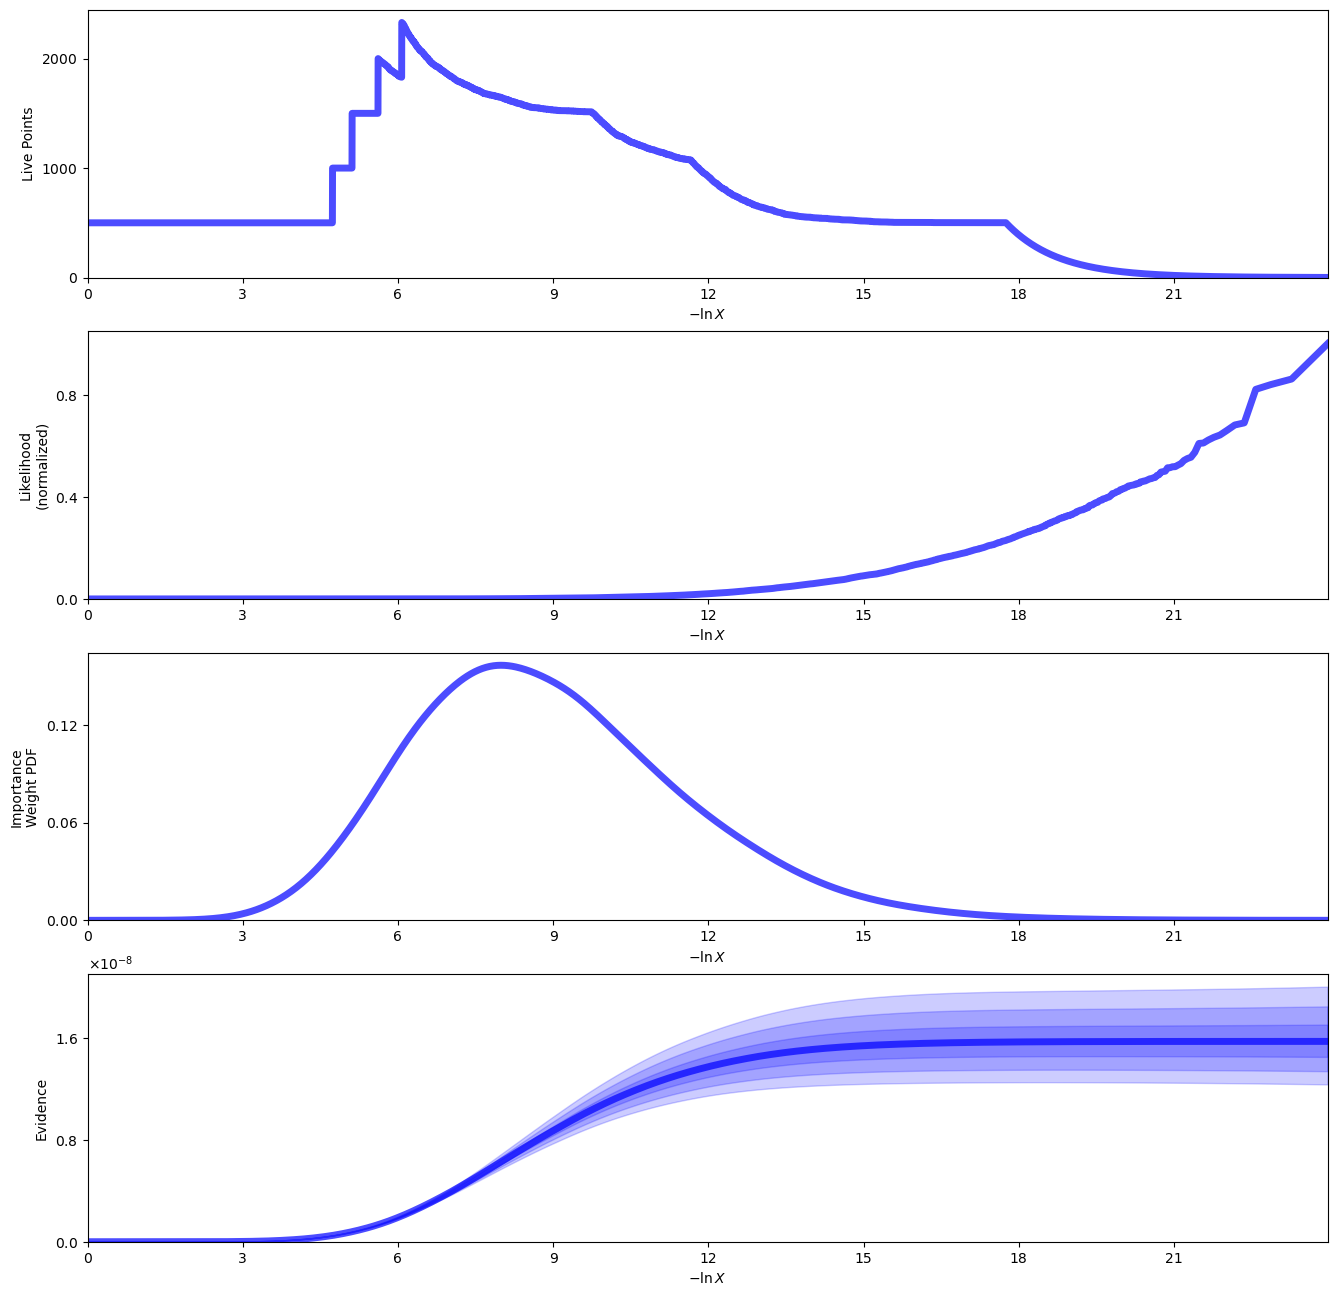

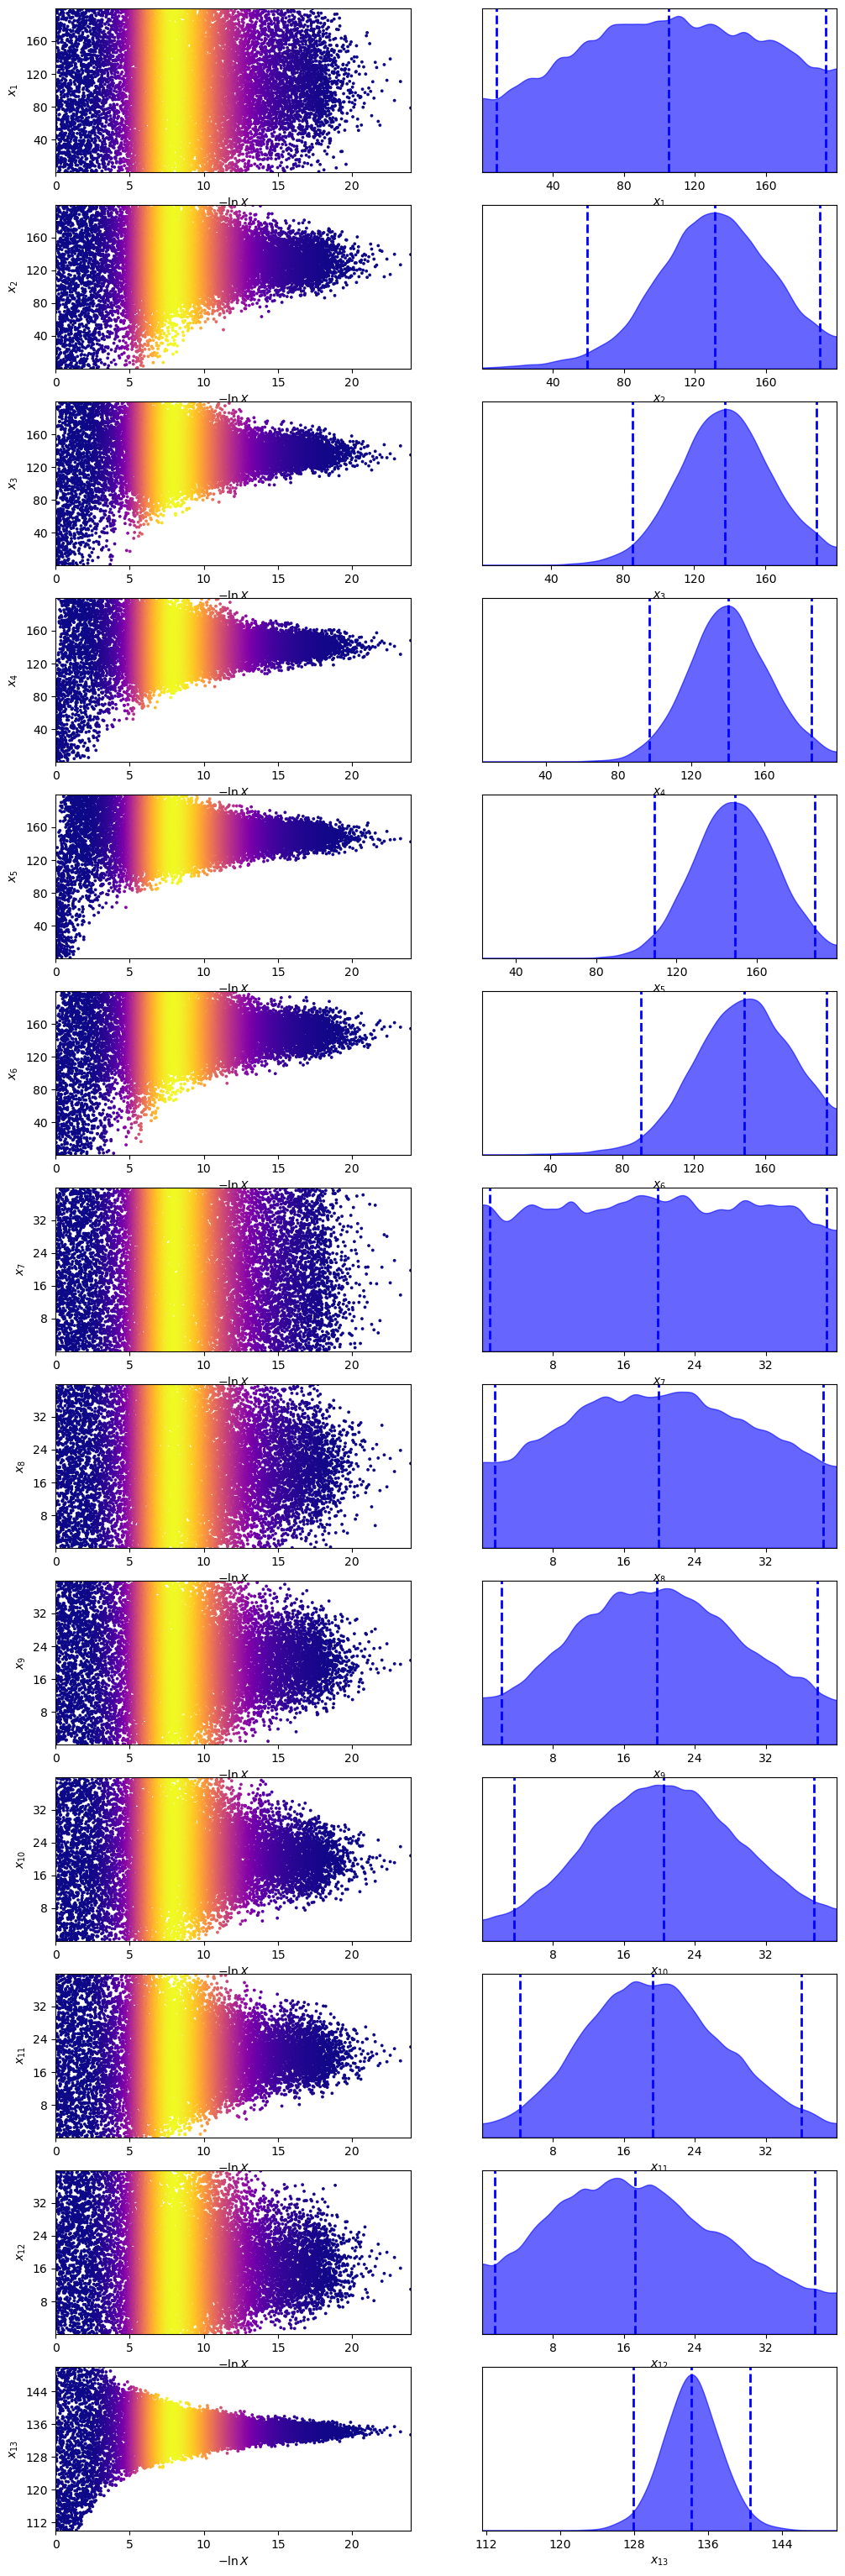

In [6]:
results = f3d.results
#print(results)

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)
rfig.savefig(outputfile+'output_run.pdf',bbox_inches='tight')

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)
tfig.savefig(outputfile+'posteriors.pdf',bbox_inches='tight')

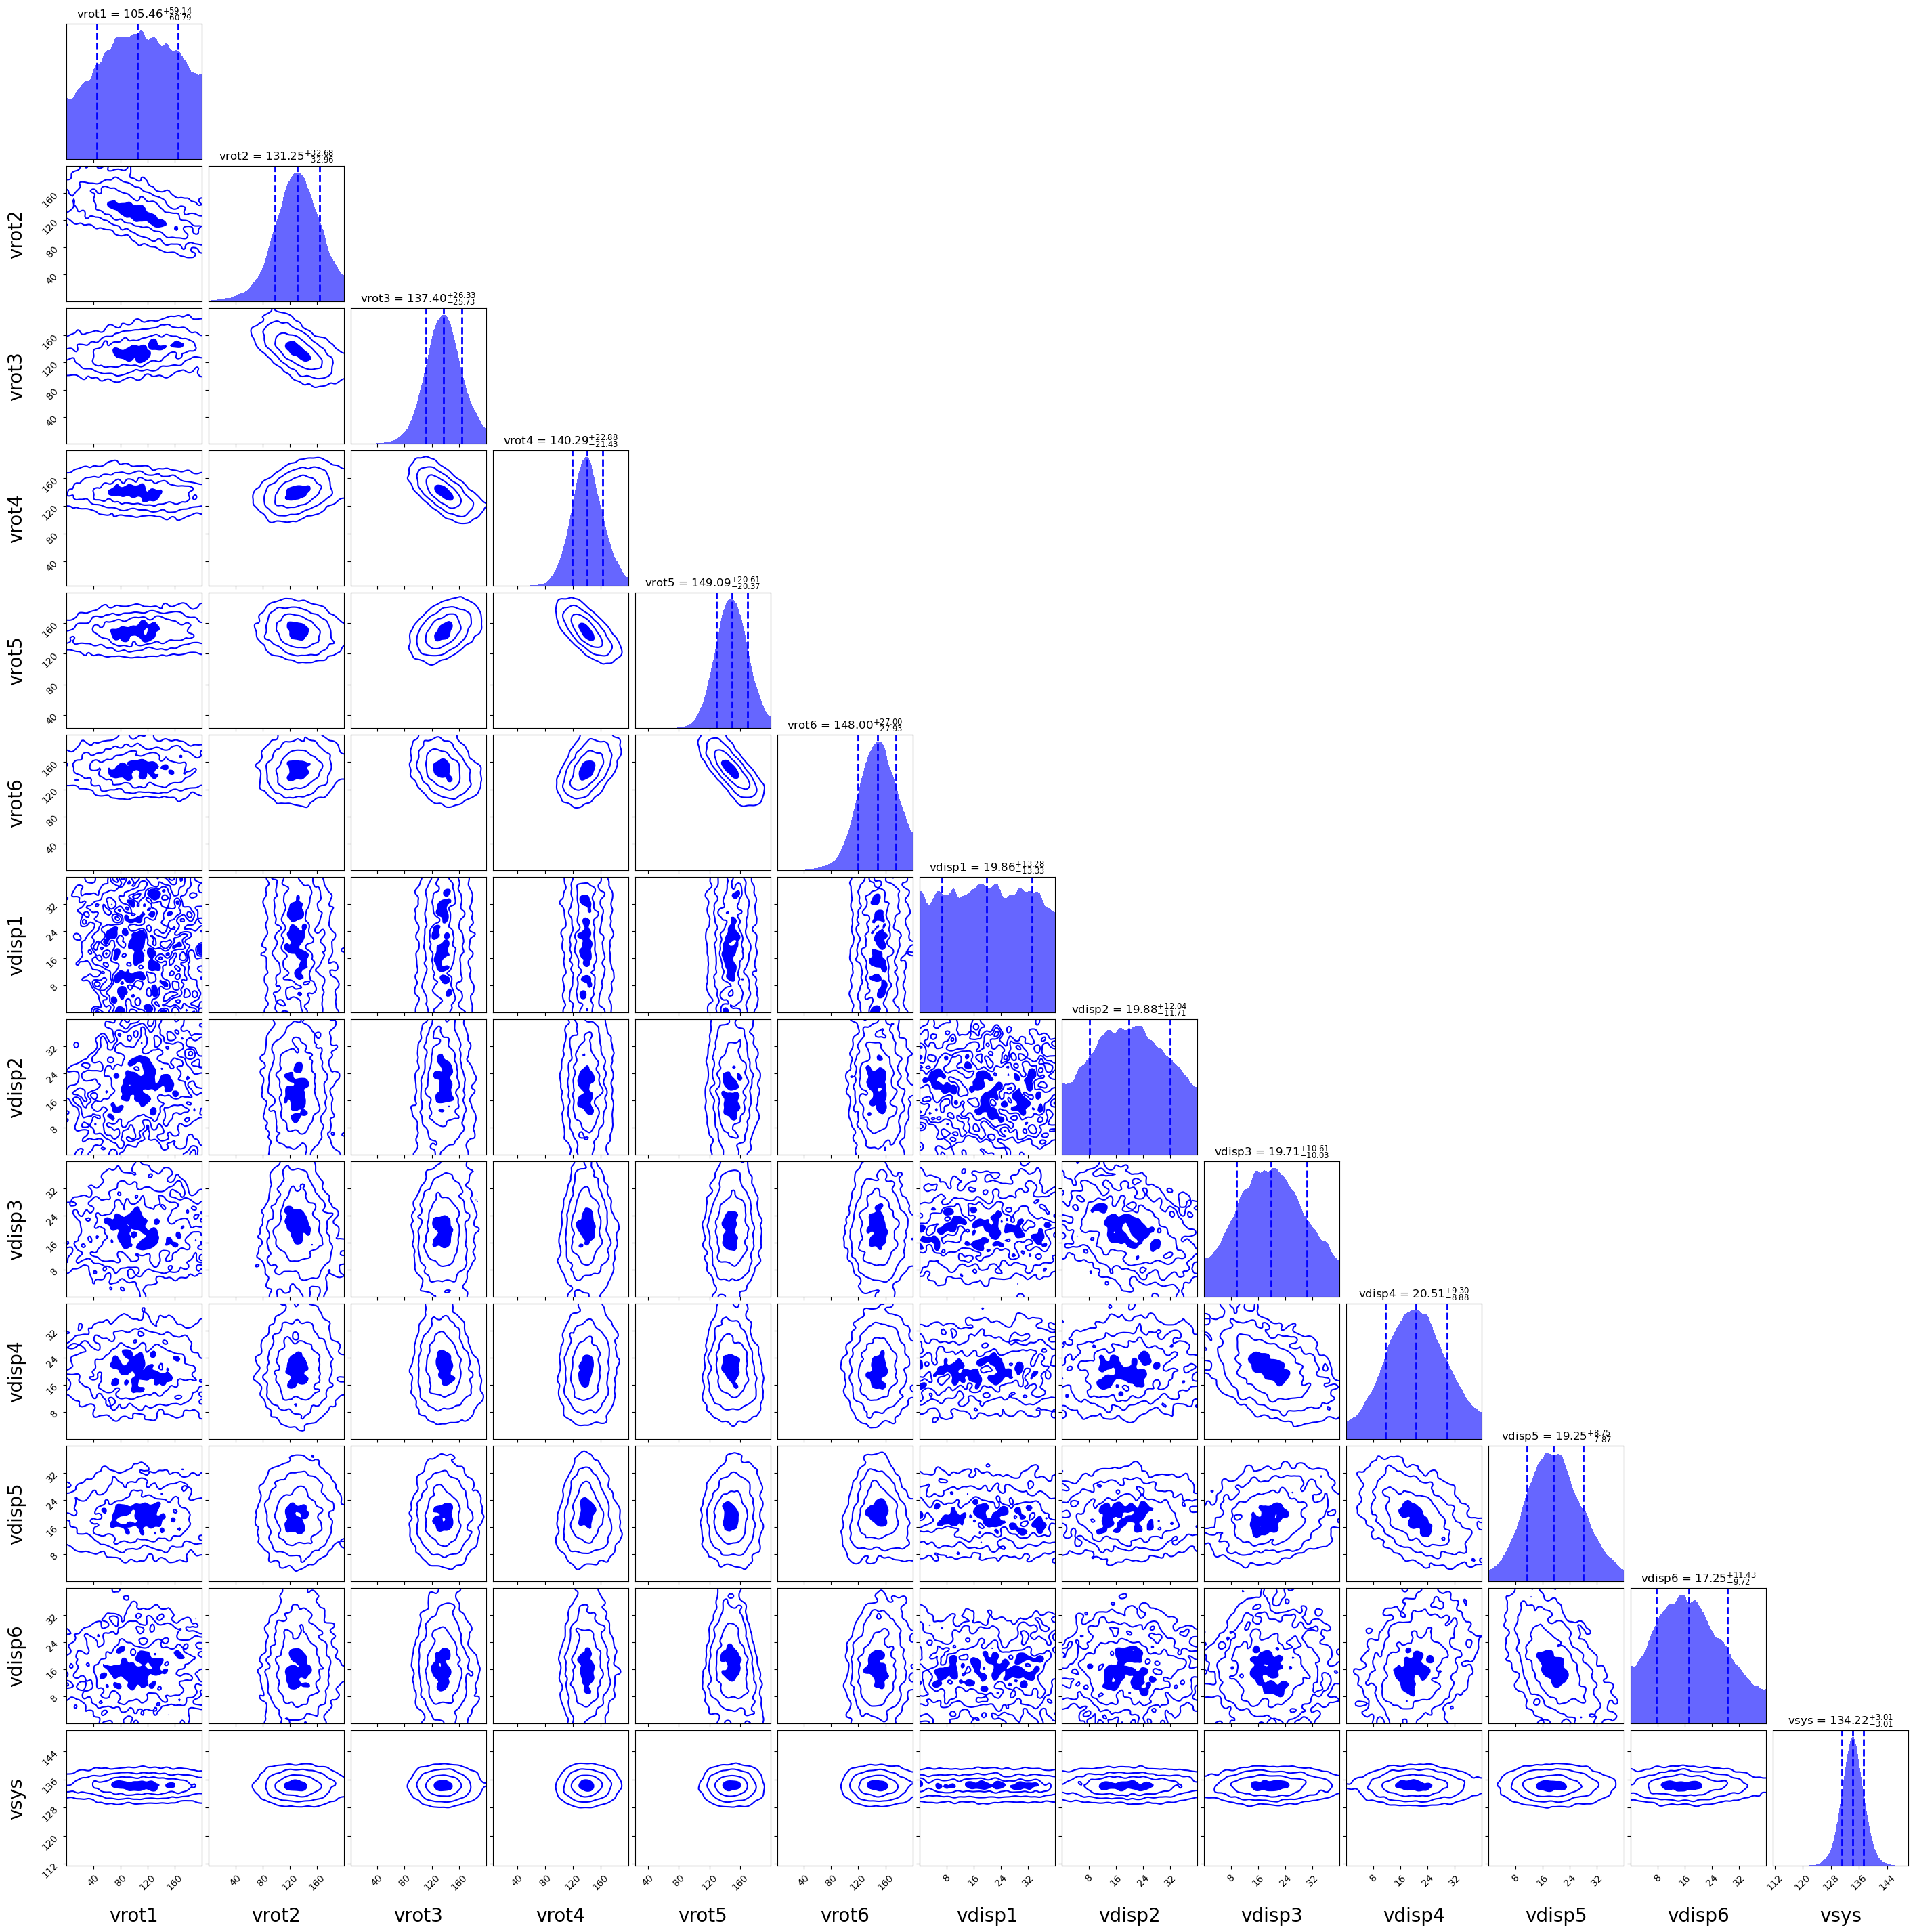

In [7]:
# Plot the 2-D marginalized posteriors.
quantiles = [0.16,0.50,0.84] # are these the contours?
cfig, caxes = dyplot.cornerplot(results,show_titles=True,title_quantiles=quantiles,
                                quantiles=quantiles, color='blue',max_n_ticks=5, labels=f3d.freepar_names, \
                                label_kwargs=dict(fontsize=20))
cfig.savefig(outputfile+'corner.pdf',bbox_inches='tight')

## Errors:

In [8]:
samples = f3d.results.samples
#print(samples) 
weights = np.exp(f3d.results.logwt - f3d.results.logz[-1])
params = np.average(samples, axis=0, weights=weights)
print (params)

labs = f3d.freepar_names
print(labs)
pp, err_up, err_low = np.zeros(shape=(3,len(params)))
for i in range(len(params)):
    mcmc = np.percentile(samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "%10s = %10.3f %+10.3f %+10.3f"%(labs[i],mcmc[1], -q[0], q[1])
    print (txt)
    pp[i] = mcmc[1]
    err_low[i] = q[0]
    err_up[i] = q[1]

[104.54055192 130.23354752 137.35142417 140.67094818 149.07206067
 146.7434144   19.88110975  19.93966555  19.84471138  20.58672287
  19.52263685  17.93630406 134.22321535]
['vrot1', 'vrot2', 'vrot3', 'vrot4', 'vrot5', 'vrot6', 'vdisp1', 'vdisp2', 'vdisp3', 'vdisp4', 'vdisp5', 'vdisp6', 'vsys']
     vrot1 =    105.345    -60.017    +59.051
     vrot2 =    130.229    -35.248    +33.030
     vrot3 =    136.722    -27.005    +26.623
     vrot4 =    139.786    -23.164    +23.186
     vrot5 =    148.628    -21.498    +21.246
     vrot6 =    146.820    -30.707    +26.884
    vdisp1 =     19.517    -13.125    +13.564
    vdisp2 =     19.899    -11.660    +11.930
    vdisp3 =     19.891     -9.998    +10.518
    vdisp4 =     20.363     -8.802     +9.350
    vdisp5 =     19.463     -8.162     +8.780
    vdisp6 =     17.412     -9.654    +11.485
      vsys =    134.154     -3.354     +3.231


## THIS CODE IS WHEN WE USE REAL DATA


#Compare with "real" input parameters, this is now comparing with the output of bbarolo (normal)

#ringfile = '/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/SGP38326/rings_final1.txt'
t = Table.read(ringfile,format='ascii')
print(t.colnames)


fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
ax = np.ravel(ax)
for a in ax:
    a.set_xlabel("radius (arcsec)")
print(f3d._inri.r.keys())
rad_mc = f3d._inri.r['radii']
print(rad_mc)
idx = f3d.freepar_idx['vrot']
ax[0].plot(t['RAD(arcs)'],t['VROT(km/s)'],label='input')
ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
ax[0].set_ylabel("vrot (km/s)")
ax[0].legend(loc='lower right')

idx = f3d.freepar_idx['vdisp']
ax[1].plot(t['RAD(arcs)'],t['DISP(km/s)'])
ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
ax[1].set_ylabel("vdisp (km/s)")

#idx = f3d.freepar_idx['inc']
#ax[2].plot(t['RAD(arcs)'],t['INC(deg)'])
#ax[2].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[2].#axhline(pp[idx][0],ls='--',color='orange')
#ax[2].set_ylabel("inc (deg)")
#ax[2].set_ylim(t['INC(deg)'][0]-20,t['INC(deg)'][0]+20)

#idx = f3d.freepar_idx['phi']
#ax[3].plot(t['RAD(arcs)'],t['P.A.(deg)'])
#ax[3].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[3].#axhline(pp[idx][0],ls='--',color='orange')
#ax[3].set_ylabel("phi (deg)")
#ax[3].set_ylim(t['P.A.(deg)'][0]-10,t['P.A.(deg)'][0]+10)

#idx = f3d.freepar_idx['z0']
#ax[4].plot(t['RAD(arcs)'],t['Z0(arcs)'])
#ax[4].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[4].axhline(pp[idx][0],ls='--',color='orange')
#ax[4].set_ylabel("z0 (arcs)")
#ax[4].set_ylim(t['Z0(arcs)'][0]-30,t['Z0(arcs)'][0]+30)

idx = f3d.freepar_idx['vsys']
ax[5].plot(t['RAD(arcs)'],t['VSYS(km/s)'])
ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[5].axhline(pp[idx][0],ls='--',color='orange')
ax[5].set_ylabel("vsys (km/s)")
ax[5].set_ylim(t['VSYS(km/s)'][0]-30,t['VSYS(km/s)'][0]+30)

#idx = f3d.freepar_idx['xpos']
#ax[6].plot(t['RAD(arcs)'],t['XPOS(pix)'])
#ax[6].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[6].axhline(pp[idx][0],ls='--',color='orange')
#ax[6].set_ylabel("xpos (pix)")
#ax[6].set_ylim(t['XPOS(pix)'][0]-5,t['XPOS(pix)'][0]+5)

#idx = f3d.freepar_idx['ypos']
#ax[7].plot(t['RAD(arcs)'],t['YPOS(pix)'])
#ax[7].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[7].axhline(pp[idx][0],ls='--',color='orange')
#ax[7].set_ylabel("ypos (pix)")
#ax[7].set_ylim(t['YPOS(pix)'][0]-5,t['YPOS(pix)'][0]+5)

fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')

## THIS CODE IS WHEN WE USE THE MODELS

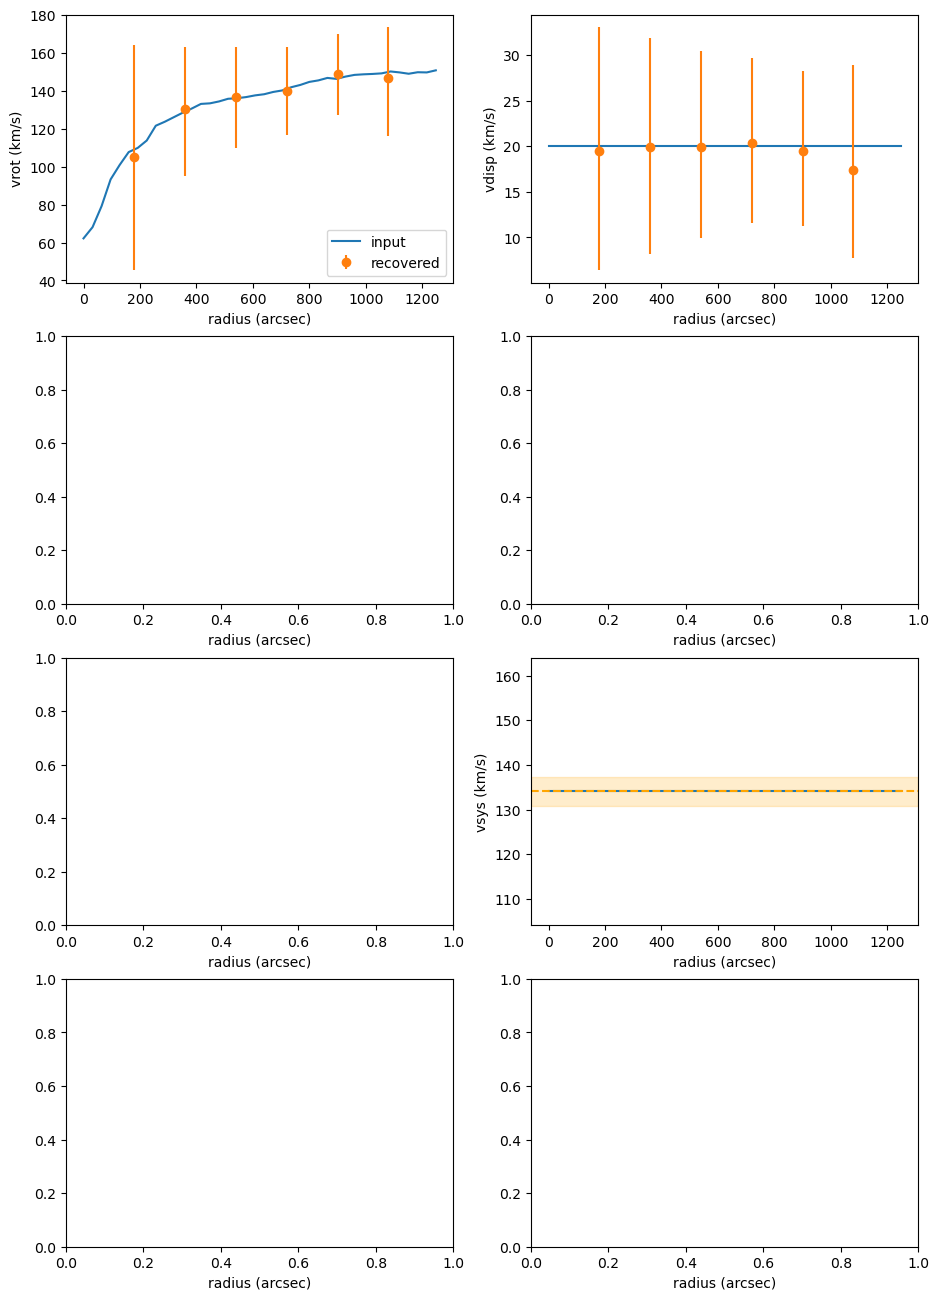

In [9]:

t = Table.read(ringfile,format='ascii')


fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
ax = np.ravel(ax)
for a in ax:
    a.set_xlabel("radius (arcsec)")

rad_mc = f3d._inri.r['radii']

idx = f3d.freepar_idx['vrot']
ax[0].plot(t['RADII'],t['VROT'],label='input')
ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
ax[0].set_ylabel("vrot (km/s)")
ax[0].legend(loc='lower right')

idx = f3d.freepar_idx['vdisp']
ax[1].plot(t['RADII'],t['VDISP'])
ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
ax[1].set_ylabel("vdisp (km/s)")

#idx = f3d.freepar_idx['inc']
#ax[2].plot(t['RADII'],t['INC'])
#ax[2].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[2].#axhline(pp[idx][0],ls='--',color='orange')
#ax[2].set_ylabel("inc (deg)")
#ax[2].set_ylim(t['INC'][0]-20,t['INC'][0]+20)

#idx = f3d.freepar_idx['phi']
#ax[3].plot(t['RADII'],t['PA'])
#ax[3].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[3].#axhline(pp[idx][0],ls='--',color='orange')
#ax[3].set_ylabel("phi (deg)")
#ax[3].set_ylim(t['PA'][0]-10,t['PA'][0]+10)

#idx = f3d.freepar_idx['z0']
#ax[4].plot(t['RADII'],t['Z0'])
#ax[4].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[4].#axhline(pp[idx][0],ls='--',color='orange')
#ax[4].set_ylabel("z0 (arcs)")
#ax[4].set_ylim(t['Z0'][0]-30,t['Z0'][0]+30)

idx = f3d.freepar_idx['vsys']
ax[5].plot(t['RADII'],t['VSYS'])
ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[5].axhline(pp[idx][0],ls='--',color='orange')
ax[5].set_ylabel("vsys (km/s)")
ax[5].set_ylim(t['VSYS'][0]-30,t['VSYS'][0]+30)

#idx = f3d.freepar_idx['xpos']
#ax[6].plot(t['RADII'],t['XPOS'])
#ax[6].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[6].#axhline(pp[idx][0],ls='--',color='orange')
#ax[6].set_ylabel("xpos (pix)")
#ax[6].set_ylim(t['XPOS'][0]-5,t['XPOS'][0]+5)

#idx = f3d.freepar_idx['ypos']
#ax[7].plot(t['RADII'],t['YPOS'])
#ax[7].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[7].#axhline(pp[idx][0],ls='--',color='orange')
#ax[7].set_ylabel("ypos (pix)")
#ax[7].set_ylim(t['YPOS'][0]-5,t['YPOS'][0]+5)

fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')

In [10]:
# If one wants to change the likelihood and/or prior, can just write a class that inherits
# from BayesianBBarolo and redefine the log_likelihood and prior_transform functions

class CustomBayesianBBarolo(BayesianBBarolo):
    def log_likelihood(self, theta):
        ...

    def prior_transform(self, u):
        ...

custom_f3d = CustomBayesianBBarolo(fitsname)


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/code/models/modelwith0.0015rms.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 



In [11]:
#inp = FitsCube(fitsname)
#mod = libBB.Galfit_new_par(inp._cube,inri._rings,opts._params)

# SOME THINGS TO DO 

- Fix parallel execution
- Play with dynesty samplers and parameters (these can be passed to compute() by dynesty_kwargs)
- Decide if residuals are calculated by BB or in python (more flexible)
- Need to implement output model generation + usual plots (various maps, pvs, etc...)
- Easily expandable to fit also other parameters (DENS, VVERT, DVDZ, ZCYL)
- Easily expandable to support functional forms for parameters
- There is a memory leak somewhere, memory usage grows when it should not (not a big problem though).